In [1]:
import pybel
from pybel import ob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import math
from mpl_toolkits import mplot3d
from scipy import linalg
from scipy.special import iv, ivp, i0
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

In [2]:
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

In [3]:
def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

In [4]:
correlated_torsion_lib = pd.read_csv("lib.txt", comment="#")

In [5]:
data = [mol for mol in pybel.readfile("sdf", "prior/COD2.sdf")]
for mol in data:
    mol.addh()

Example 1

Use bivariate von Mises distribution (cosine submodel with negative inteaction) to model the correlated torsions

In [6]:
pattern = correlated_torsion_lib["SMARTS"][18]
writer = pybel.Outputfile("sdf", "pattern_18_example.sdf", overwrite=True)
for mol in data: 
    smarts = pybel.Smarts(correlated_torsion_lib["SMARTS"][18])
    if any(smarts.findall(mol)):
        writer.write(mol)
        writer.close()
        break

Figure 1: 

one example from the filtered COD set with substructure

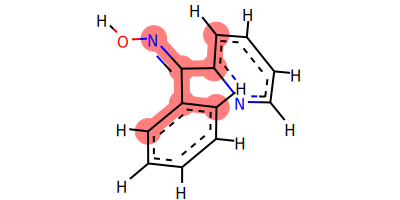

In [11]:
mol_0 = Chem.SDMolSupplier("pattern_18_example.sdf", removeHs=False)
SVG(moltosvg(mol_0[0]))
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol_0[0], highlightAtoms=mol_0[0].GetSubstructMatch(Chem.MolFromSmarts(pattern)))
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

Figure 2

In [12]:
drawit(mol_0[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
# COD 2-10 rotatable bonds
cod = []
for dirs, locs, file in os.walk("prior/"):
    for x in file:
        if x.endswith(".sdf"):
            cod.append([mol for mol in pybel.readfile("sdf", os.path.join(dirs,x))])
full = [mol for item in cod for mol in item]
for mol in full:
    mol.addh()

In [14]:
len(full)  # total number of molecules in the filtered COD

64509

In [15]:
correlated_torsions = []
count = [] # count how many molecules in the set contain same substructure
smarts = pybel.Smarts(pattern)
for mol in full:
    if any(smarts.findall(mol)):
        pos1, pos2, pos3, pos4 = correlated_torsion_lib.iloc[18,1:5]
        pos5, pos6, pos7, pos8 = correlated_torsion_lib.iloc[18,5:9]
        count.append(mol)
        for i in smarts.findall(mol): # accumulate all observations
            angle1 = math.radians(mol.OBMol.GetTorsion(i[int(pos1)], i[int(pos2)], i[int(pos3)], i[int(pos4)]))
            angle2 = math.radians(mol.OBMol.GetTorsion(i[int(pos5)], i[int(pos6)], i[int(pos7)], i[int(pos8)]))
            correlated_torsions.append([angle1, angle2])

In [16]:
print(len(count)) # substructure is found in 179 molecules  (out of 64509) 

179


Figure 3

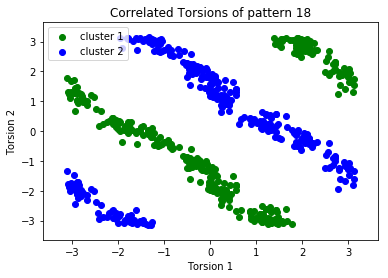

In [17]:
dataframe = pd.DataFrame(correlated_torsions, columns=["torsion_1", "torsion_2"])
cluster = []
for item in dataframe.iterrows():
    if (0.05*np.cos(item[1][0]-1.1) + 0.05*np.cos(item[1][1]-.5) - 5*np.cos(item[1][0]-1.1-0.5+item[1][1])<0.1):
        cluster.append(1)
    else:
        cluster.append(0)
dataframe["cluster"] = cluster
group_0 = dataframe.groupby("cluster").get_group(0)   
group_1 = dataframe.groupby("cluster").get_group(1)   
plt.scatter(group_0["torsion_1"], group_0["torsion_2"], color="green", label="cluster 1")
plt.scatter(group_1["torsion_1"], group_1["torsion_2"], color="blue", label="cluster 2")
plt.xlim(-math.pi-.5, math.pi+.5)
plt.ylim(-math.pi-.5, math.pi+.5)
plt.title("Correlated Torsions of pattern 18")
plt.xlabel("Torsion 1")
plt.ylabel("Torsion 2")
plt.legend(loc="upper left")
plt.show()

# The correlated torsion angles are points on the torsus
# We can see two clusters below (blue and green)


Bivariate von Misms mixture model (cosine submodel with negative interaction)

From figure 3: low concentration $\kappa_1$ and $\kappa_2$ and high correlation $\kappa_3$

In [18]:
def compute_normalizing_constant(kappa_1, kappa_2, kappa_3):
    """
    Pre-computing the normalizing to speed up the calculation
    """
    kappas = [kappa_1, kappa_2 ,kappa_3]
    bessel_0 = list(map(lambda k: i0(k), kappas))
    bessel_order = [list(map(lambda j: iv(r,j), kappas)) for r in range(1,10000)]  # r is the order
    product_bessel_0 = np.prod(bessel_0)
    product_bessel_order = list(map(lambda p: np.prod(p), bessel_order))
    assert product_bessel_order[-3:] == [0,0,0], "Wrong Normalizing Constant"
    normalized_c = np.square(2*math.pi)*(product_bessel_0 + 2*np.sum(product_bessel_order))
    return normalized_c     

def bivariate_negative(x,y,mu,vu,kappa1,kappa2,kappa3, normalizing_constant):
    """
    cosine submodel with negative interaction
    """
    outcome = np.exp(kappa1*np.cos([x-mu])+kappa2*np.cos([y-vu])-kappa3*np.cos([x-mu+y-vu]))
    density = outcome/normalizing_constant
    return density

def bivariate_positive(x,y,mu,vu,kappa1,kappa2,kappa3, normalizing_constant):
    """
    cosine submodel with positive interaction
    """
    outcome = np.exp(kappa1*np.cos([x-mu])+kappa2*np.cos([y-vu])-kappa3*np.cos([x-mu-y+vu]))
    density = outcome/normalizing_constant
    return density

Figure 4

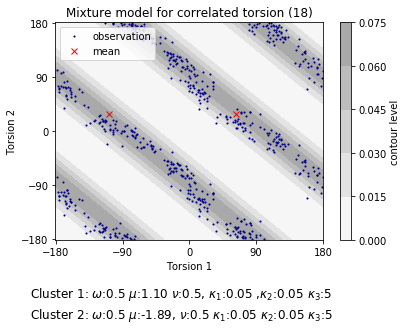

In [39]:
x = np.linspace(-math.pi,math.pi,200)
y = np.linspace(-math.pi,math.pi, 200)
X,Y =np.meshgrid(x,y)
constant = compute_normalizing_constant(.05, .05, 5)
cluster0 = np.vectorize(bivariate_negative)(X,Y, 1.1,0.5,.05,.05,5, constant)
cluster1 = np.vectorize(bivariate_negative)(X,Y,-1.89,0.5,.05,.05,5, constant)
density = 0.5*cluster0+0.5*cluster1
X_degree, Y_degree = X*180/np.pi, Y*180/np.pi
dataframe_degree = dataframe*180/np.pi


fig = plt.figure()
ax = plt.axes()
plt.plot(dataframe_degree["torsion_1"], dataframe_degree["torsion_2"], "o", markersize=1.1, color="darkblue",label="observation")
plt.plot(1.1*180/np.pi, 0.5*180/np.pi, "x", color="red", label="mean")
plt.plot(-1.89*180/np.pi, 0.5*180/np.pi, "x", color="red")
cs = ax.contourf(X_degree,Y_degree, density,5, cmap="binary", vmax=0.2)

plt.xlim(-180.5,180.5)
plt.ylim(-180.5,180.5)
fig.colorbar(cs, label="contour level")
plt.xlabel(r"Torsion 1")
plt.ylabel(r"Torsion 2")
plt.xticks([-180,-90, 0 , 90, 180])
plt.yticks([-180,-90, 0 , 90, 180])
plt.title("Mixture model for correlated torsion (18)")
plt.text(-215,-275,r"Cluster 1: $\omega$:0.5 $\mu$:1.10 $\nu$:0.5, $\kappa_1$:0.05 ,$\kappa_2$:0.05 $\kappa_3$:5", fontsize=12)
plt.text(-215,-310,r"Cluster 2: $\omega$:0.5 $\mu$:-1.89, $\nu$:0.5 $\kappa_1$:0.05 $\kappa_2$:0.05 $\kappa_3$:5", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("pattern_18_fig.pdf", dpi=300,  bbox_inches="tight")
plt.show()

Example 2

Use bivariate von Mises distribution (cosine submodel with positive inteaction) to model the correlated torsions

In [40]:
pattern = correlated_torsion_lib["SMARTS"][2]
writer = pybel.Outputfile("sdf", "pattern_2_example.sdf", overwrite=True)
for mol in data: 
    smarts = pybel.Smarts(correlated_torsion_lib["SMARTS"][2])
    if any(smarts.findall(mol)):
        writer.write(mol)
        writer.close()
        break

Figure 5

Pick one example from the filtered COD set with substructure

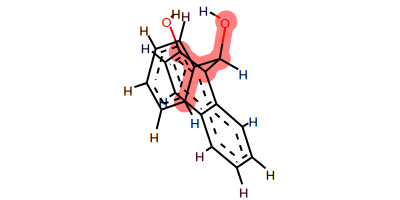

In [43]:
mol_1 = Chem.SDMolSupplier("pattern_2_example.sdf", removeHs=False)
SVG(moltosvg(mol_1[0]))
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol_1[0], highlightAtoms=mol_1[0].GetSubstructMatch(Chem.MolFromSmarts(pattern)))
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

Figure 6

In [44]:
drawit(mol_1[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [45]:
correlated_torsions = []
count = [] # count how many molecules in the set contain same substructure
smarts = pybel.Smarts(pattern)
for mol in full:
    if any(smarts.findall(mol)):
        pos1, pos2, pos3, pos4 = correlated_torsion_lib.iloc[2,1:5]
        pos5, pos6, pos7, pos8 = correlated_torsion_lib.iloc[2,5:9]
        count.append(mol)
        for i in smarts.findall(mol): # accumulate all observations
            angle1 = math.radians(mol.OBMol.GetTorsion(i[int(pos1)], i[int(pos2)], i[int(pos3)], i[int(pos4)]))
            angle2 = math.radians(mol.OBMol.GetTorsion(i[int(pos5)], i[int(pos6)], i[int(pos7)], i[int(pos8)]))
            correlated_torsions.append([angle1, angle2])

Figure 7

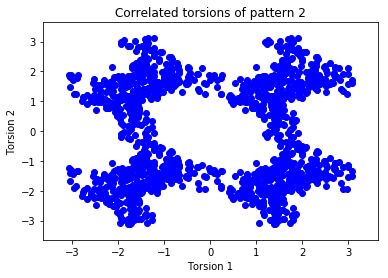

In [46]:
dataframe = pd.DataFrame(correlated_torsions, columns=["torsion_1", "torsion_2"])
plt.scatter(dataframe["torsion_1"], dataframe["torsion_2"], color="blue")
plt.xlim(-math.pi-.5, math.pi+.5)
plt.ylim(-math.pi-.5, math.pi+.5)
plt.title("Correlated torsions of pattern 2")
plt.xlabel("Torsion 1")
plt.ylabel("Torsion 2")
plt.show()

we can see four clusters in the Figure 7

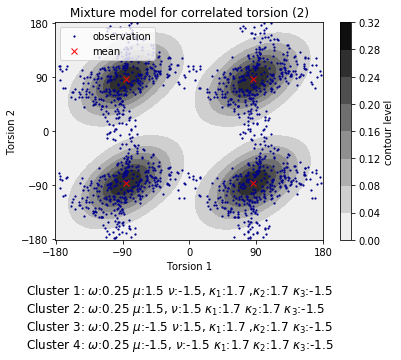

In [61]:
# Pattern 2
x = np.linspace(-math.pi,math.pi,200)
y = np.linspace(-math.pi,math.pi, 200)
X,Y =np.meshgrid(x,y)
constant = compute_normalizing_constant(1.7,1.7,-1.5)
out = np.vectorize(bivariate_positive)(X,Y,-1.5,1.5,1.7,1.7,-1.5, constant)
out1 = np.vectorize(bivariate_positive)(X,Y,-1.5,-1.5,1.7,1.7,-1.5, constant)
out2 = np.vectorize(bivariate_positive)(X,Y,1.5,-1.5,1.7,1.7,-1.5, constant)
out3 = np.vectorize(bivariate_positive)(X,Y,1.5,1.5,1.7,1.7,-1.5, constant)
final = 0.25*out+0.25*out1+.25*out2+.25*out3
X_degree, Y_degree = X*180/np.pi, Y*180/np.pi
dataframe_degree = dataframe*180/np.pi
fig = plt.figure()
ax = plt.axes()
plt.xlim(-180.5,180.5)
plt.ylim(-180.5,180.5)
plt.xticks([-180,-90,0,90,180])
plt.yticks([-180,-90,0,90,180])
cs = ax.contourf(X_degree,Y_degree, final, cmap="binary")
plt.plot(dataframe_degree["torsion_1"], dataframe_degree["torsion_2"], "o", markersize=1.2, color="darkblue", label="observation")
plt.plot([-1.5*180/np.pi,-1.5*180/np.pi,1.5*180/np.pi,1.5*180/np.pi], [-1.5*180/np.pi,1.5*180/np.pi,-1.5*180/np.pi,1.5*180/np.pi], "x", color="red", label="mean")
fig.colorbar(cs, label="contour level")
plt.xlabel(r"Torsion 1")
plt.ylabel(r"Torsion 2")
plt.title("Mixture model for correlated torsion (2)")
plt.text(-220,-270,r"Cluster 1: $\omega$:0.25 $\mu$:1.5 $\nu$:-1.5, $\kappa_1$:1.7 ,$\kappa_2$:1.7 $\kappa_3$:-1.5", fontsize=12)
plt.text(-220,-300,r"Cluster 2: $\omega$:0.25 $\mu$:1.5, $\nu$:1.5 $\kappa_1$:1.7 $\kappa_2$:1.7 $\kappa_3$:-1.5", fontsize=12)
plt.text(-220,-330,r"Cluster 3: $\omega$:0.25 $\mu$:-1.5 $\nu$:1.5, $\kappa_1$:1.7 ,$\kappa_2$:1.7 $\kappa_3$:-1.5", fontsize=12)
plt.text(-220,-360,r"Cluster 4: $\omega$:0.25 $\mu$:-1.5, $\nu$:-1.5 $\kappa_1$:1.7 $\kappa_2$:1.7 $\kappa_3$:-1.5", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("pattern_2_fig.pdf", dpi=300, bbox_inches="tight")
plt.show()